In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Dataset & Dataloader

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
bs = 64 

transform = transforms.Compose([
    transforms.Grayscale(),    
    transforms.ToTensor(),
])

train_set = datasets.ImageFolder("data/train/", transform=transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = datasets.ImageFolder("data/test/", transform=transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

# Arsitektur & Config

In [4]:
from jcopdl.layers import linear_block

In [5]:
class AutoEncoder(nn.Module):
    def __init__(self, z_size):
        super().__init__()
        self.encode = nn.Sequential(
            linear_block(784, 512, batch_norm=True),
            linear_block(512, 256, batch_norm=True),
            linear_block(256, z_size, activation='sigmoid')
        )
        
        self.decode = nn.Sequential(
            linear_block(z_size, 256, batch_norm=True),
            linear_block(256, 512, batch_norm=True),
            linear_block(512, 784, activation='sigmoid')
        )                                
                        
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

In [6]:
config = set_config ({
    "z_size": 32,
    "batch_size": bs
})

# Training Preparation -> MCOC

In [7]:
model = AutoEncoder(config.z_size).to(device)

# Load Model

In [8]:
weights = torch.load("model/ae/weights_best.pth", map_location="cpu")
model.load_state_dict(weights)
model = model.to(device);  

# Evaluate

In [9]:
feature, target = next(iter(testloader))
feature = feature.view(-1, 784).to(device)

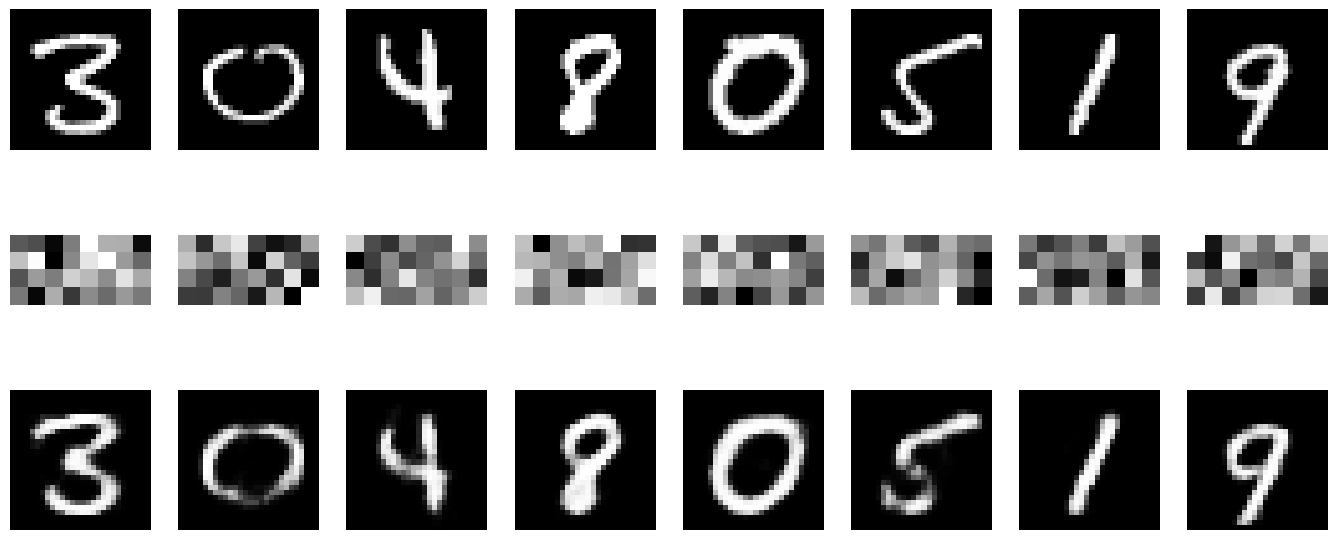

In [10]:
with torch.no_grad():
    model.eval()
    
    enc = model.encode(feature)
    dec = model.decode(enc)

fig, ax = plt.subplots(3, 8, figsize=(17, 7))

for i in range(8):
    ax[0, i].imshow(feature[i].view(28, 28).cpu(), cmap="gray")
    ax[0, i].axis("off")
    
    ax[1, i].imshow(enc[i].view(4, 8).cpu(), cmap="gray")
    ax[1, i].axis("off")
    
    ax[2, i].imshow(dec[i].view(28, 28).cpu(), cmap="gray")
    ax[2, i].axis("off")

# Playground

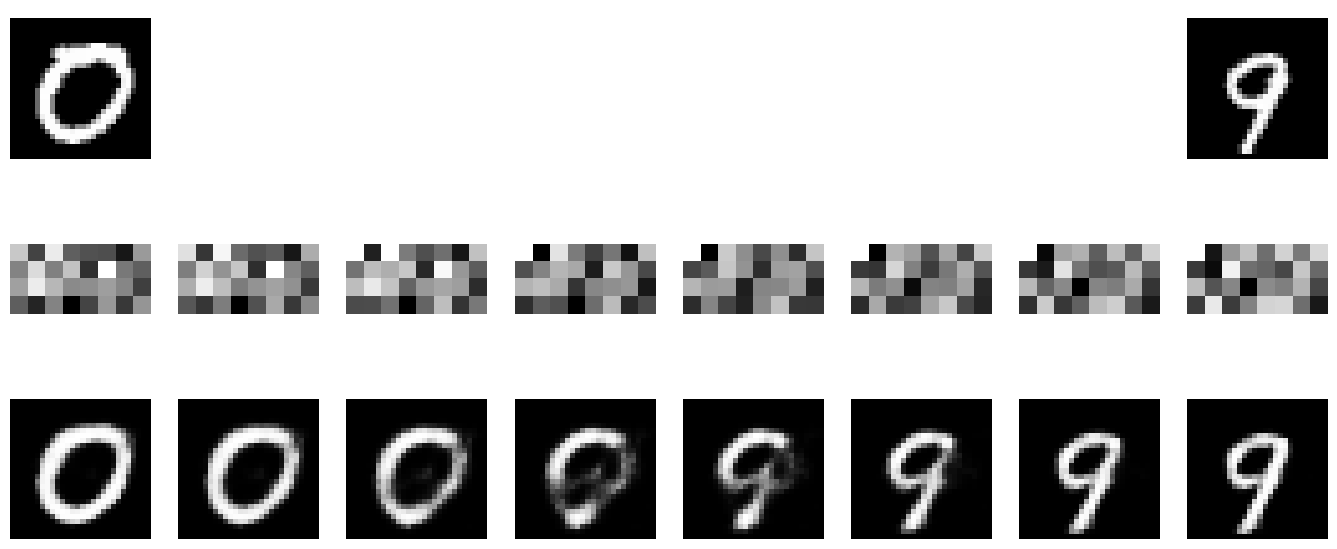

In [11]:
with torch.no_grad():
    model.eval()
    enc = model.encode(feature)
    
    code1, code2 = enc[4], enc[7]
    codes = [(1-i)*code1 + i*code2 for i in np.linspace(0, 1, 8)]
    enc = torch.stack(codes)
    
    dec = model.decode(enc)

fig, ax = plt.subplots(3, 8, figsize=(17, 7))

ax[0, 0].imshow(feature[4].view(28, 28).cpu(), cmap="gray")
ax[0, 7].imshow(feature[7].view(28, 28).cpu(), cmap="gray")

for i in range(8):
    ax[0, i].axis("off")
    
    ax[1, i].imshow(enc[i].view(4, 8).cpu(), cmap="gray")
    ax[1, i].axis("off")
    
    ax[2, i].imshow(dec[i].view(28, 28).cpu(), cmap="gray")
    ax[2, i].axis("off")

# Denoising Autoencoder

In [12]:
def add_noise(images, noise_factor=0.3):
    images = torch.clone(images)
    images += noise_factor * torch.rand_like(images)
    images = images.clamp(0., 1.)
    return images

(-0.5, 27.5, 27.5, -0.5)

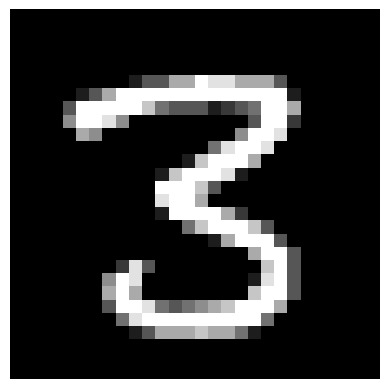

In [13]:
plt.imshow(feature[0].view(28, 28).cpu(), cmap="gray")
plt.axis("off")

(-0.5, 27.5, 27.5, -0.5)

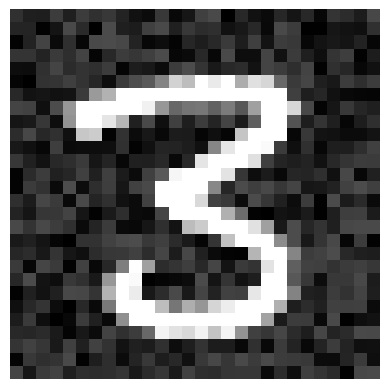

In [14]:
plt.imshow(add_noise(feature[0]).view(28, 28).cpu(), cmap="gray")
plt.axis("off")

# Training Preparation

In [15]:
model = AutoEncoder(config.z_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model/dae")

# Training Loop

## Fiturnya dikasih noise, dan outputnya tetap bersih

In [16]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, _ in tqdm(dataloader, desc=mode.title()):
        feature = feature.view(-1, 784).to(device)
        
        output = model(add_noise(feature))
        loss = criterion(output, feature)

        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost

Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.3360 | Test_cost  = 0.2632 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.1856 | Test_cost  = 0.1778 | 


Train:   0%|          | 0/25 [00:40<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.1611 | Test_cost  = 0.1549 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.1469 | Test_cost  = 0.1442 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.1376 | Test_cost  = 0.1363 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.1298 | Test_cost  = 0.1308 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.1249 | Test_cost  = 0.1270 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.1198 | Test_cost  = 0.1254 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.1163 | Test_cost  = 0.1193 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.1130 | Test_cost  = 0.1178 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.1094 | Test_cost  = 0.1157 | 


Train:   0%|          | 0/25 [02:40<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.1073 | Test_cost  = 0.1131 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.1055 | Test_cost  = 0.1109 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.1029 | Test_cost  = 0.1099 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.1008 | Test_cost  = 0.1093 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.0997 | Test_cost  = 0.1092 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.0988 | Test_cost  = 0.1077 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.0968 | Test_cost  = 0.1062 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.0957 | Test_cost  = 0.1057 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.0942 | Test_cost  = 0.1053 | 


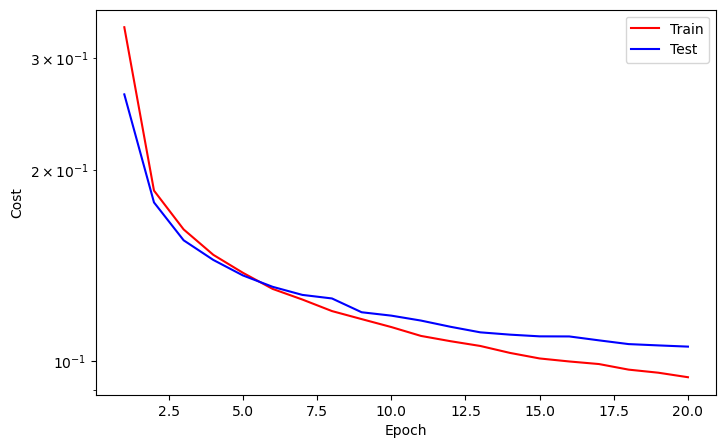

Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.0939 | Test_cost  = 0.1056 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1053


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.0930 | Test_cost  = 0.1043 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 0.0923 | Test_cost  = 0.1041 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 0.0914 | Test_cost  = 0.1037 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 0.0902 | Test_cost  = 0.1026 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 0.0901 | Test_cost  = 0.1032 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1026


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 0.0892 | Test_cost  = 0.1029 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1026


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 0.0887 | Test_cost  = 0.1032 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1026


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 0.0881 | Test_cost  = 0.1022 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 0.0880 | Test_cost  = 0.1011 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 0.0869 | Test_cost  = 0.1012 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1011


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 0.0873 | Test_cost  = 0.1018 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1011


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 0.0865 | Test_cost  = 0.1017 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1011


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 0.0857 | Test_cost  = 0.1009 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 0.0848 | Test_cost  = 0.1010 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1009


Train:   0%|          | 0/25 [02:40<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 0.0846 | Test_cost  = 0.1021 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1009


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 0.0844 | Test_cost  = 0.1014 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1009


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 0.0839 | Test_cost  = 0.1012 | 
==> EarlyStop patience =  4 | Best test_cost: 0.1009


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 0.0835 | Test_cost  = 0.1012 | 
==> EarlyStop patience =  5 | Best test_cost: 0.1009
==> Execute Early Stopping at epoch: 39 | Best test_cost: 0.1009
==> Best model is saved at model/dae


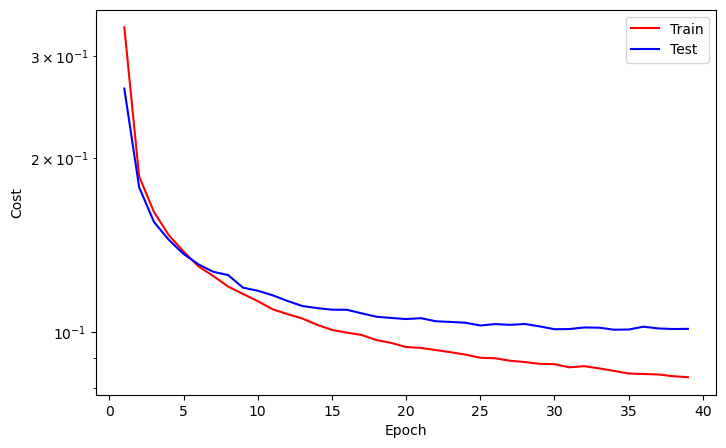

In [17]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()
        
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break